In [1]:
"""
This script can be used as skelton code to read the challenge train and test
geojsons, to train a trivial model, and write data to the submission file.
"""
import geopandas as gpd
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from datetime import date

from shapely.geometry import Polygon, Point
import seaborn as sns
import matplotlib.pyplot as plt

import random as rd


In [2]:
df = gpd.read_file('train.geojson', index_col=0)
df = df.drop(columns=['index'])

In [3]:
df_submission = gpd.read_file('test.geojson', index_col=0)
df_submission = df_submission.drop(columns=['index'])

# **2) Preprocessing data**

### Preparing encoding

In [4]:
n = len(df)
m = len(df_submission)

# Change_status_date encoder
status_date = pd.concat([df['change_status_date1'], df['change_status_date2'], df['change_status_date3'], df['change_status_date4'], df['change_status_date5']])
encoder_status_date = LabelEncoder()
encoder_status_date.fit(status_date)

# List of urban_types
urban_types = []
for i in range(n):
  new = df['urban_types'][i].split(',')
  for word in new:
    if not (word in urban_types):
      urban_types.append(word)

# List of geography_types
geography_types = []
for i in range(n):
  new = df['geography_types'][i].split(',')
  for word in new:
    if not (word in geography_types):
      geography_types.append(word)

for i in range(m):
  new = df_submission['geography_types'][i].split(',')
  for word in new:
    if not (word in geography_types):
      geography_types.append(word)

### Encoding functions

In [42]:
# Encoding of change_status_date
def encode_change_status_date(df):
  for i in '12345':
    df['change_status_date'+i] = encoder_status_date.transform(df['change_status_date'+i])
  
  return df

# Adding the number of times each category 'change_status_date' is present in a row
def add_number_change(df):
    n = len(df)
    l = [0 for i in range(n)]
    for i in range(10):
        df['number_of_change'+str(i)] = l.copy()
    
    for i in range(1,6):
        for j in range(n):
            label = str(df['change_status_date'+str(i)][j])
            df['number_of_change'+str(label)][j] += 1
    
    return df

# Encoding of dates
def encode_dates(df):
  def distance_dates(date1, date2):
    return abs((date(int(date2[2]), int(date2[1]), int(date2[0])) - date(int(date1[2]), int(date1[1]), int(date1[0]))).days)

  n = len(df)
  for i in range(n):
    date1, date2, date3, date4, date5 = df['date1'][i].split('-'),  df['date2'][i].split('-'),  df['date3'][i].split('-'), df['date4'][i].split('-'), df['date5'][i].split('-')
    
    df['date5'][i] = distance_dates(date4, date5)
    df['date4'][i] = distance_dates(date3, date4)
    df['date3'][i] = distance_dates(date2, date3)
    df['date2'][i] = distance_dates(date1, date2)
    df['date1'][i] = 0

  return df

# Encoding of urban_types
def encode_urban_types(df):
  n = len(df)
  for urban in urban_types:
    df[urban] = np.zeros(n, dtype=int)

  for i in range(n):
    urbans = df['urban_types'][i].split(',')
    for urban in urbans:
      df[urban][i] = 1 

  df = df.drop(columns=['urban_types'])

  return df

# Encoding of geography_types
def encode_geography_types(df):
  n = len(df)
  for geography in geography_types:
    df[geography] = np.zeros(n, dtype=int)

  for i in range(n):
    geographies = df['geography_types'][i].split(',')
    for geography in geographies:
      df[geography][i] = 1 

  df = df.drop(columns=['geography_types'])

  return df

### Polygon encoding functions

In [ ]:
# Encoding of polygon
def get_aspect_ratio(poly):
  bounds = poly.bounds
  dist_y = bounds[2] - bounds[0]
  dist_x = bounds[3] - bounds[1]
  return min(dist_x/dist_y, dist_y/dist_x)

def get_dist_x(poly):
  bounds = poly.bounds
  return (bounds[3] - bounds[1])

def get_dist_y(poly):
  bounds = poly.bounds
  return (bounds[2] - bounds[0])

def encode_polygon(df):
  df['area'] = np.asarray(df[['geometry']].area)
  df['length'] = np.asarray(df[['geometry']].length)
  df['min_x'] = df['geometry'].apply(lambda poly: poly.bounds[0])
  df['max_x'] = df['geometry'].apply(lambda poly: poly.bounds[2])
  df['min_y'] = df['geometry'].apply(lambda poly: poly.bounds[1])
  df['max_y'] = df['geometry'].apply(lambda poly: poly.bounds[3])
  df['dist_x'] = (df['max_x'] - df['min_x'])*10000
  df['dist_y'] = (df['max_y'] - df['min_y'])*10000
  df['number_of_points'] = df['geometry'].apply(lambda poly: len(poly.exterior.coords))
  df['aspect_ratio'] = df['geometry'].apply(get_aspect_ratio)
  df['area_around'] = df['dist_x']*df['dist_y']

  df = df.drop(columns=['geometry'])

  return df

### Encoding train and test data

In [43]:
# Preprocess data
import time as t

def preprocess_data(df):
  t1 = t.time()
  df = encode_change_status_date(df)
  print("Step 1/6 completed - Time : ", t.time()-t1)

  t1 = t.time()
  df = add_number_change(df)
  print("Step 2/6 completed - Time : ", t.time()-t1)
    
  t1 = t.time()
  df = encode_dates(df)
  df = df.drop(columns=['date1'])
  print("Step 3/6 completed - Time : ", t.time()-t1)

  t1 = t.time()
  df = encode_urban_types(df)
  df = df.rename(columns={'None': 'None_urban'}, inplace=False)
  print("Step 4/6 completed - Time : ", t.time()-t1)

  t1 = t.time()
  df = encode_geography_types(df)
  df = df.rename(columns={'None': 'None_geography'}, inplace=False)
  print("Step 5/6 completed - Time : ", t.time()-t1)

  t1 = t.time()
  df = encode_polygon(df)
  print("Step 6/6 completed - Time : ", t.time()-t1)

  return df

df = preprocess_data(df)
df_submission = preprocess_data(df_submission)

### Encoding labels for the train dataset

In [ ]:
def encode_labels(df):
    change_type_map = {'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
           'Mega Projects': 5}

    df['change_type'] = df['change_type'].apply(lambda x: change_type_map[x])
    
    return df

df = encode_labels(df)

In [166]:
df.head()

,change_type,change_status_date1,change_status_date2,change_status_date3,change_status_date4,change_status_date5,date2,date3,date4,date5,...,Grass Land,Farms,Lakes,Barren Land,Coastal,Dense Forest,None_geography,Hills,Desert,Snow
0,3,5,1,0,0,0,472,531,592,587,...,1,0,0,0,0,0,0,0,0,0
1,3,4,4,0,0,0,472,531,592,587,...,1,0,0,0,0,0,0,0,0,0
2,3,5,5,0,0,0,472,531,592,587,...,1,0,0,0,0,0,0,0,0,0
3,3,5,5,1,1,0,472,531,592,587,...,1,0,0,0,0,0,0,0,0,0
4,3,5,5,2,1,0,472,531,592,587,...,1,0,0,0,0,0,0,0,0,0


### Normalizing data (no longer useful since we use random forest)

In [7]:
# max_perimeter = max(df['perimeter'])
# max_aspect_ratio = max(df['aspect_ratio'])
# max_area = max(df['area'])
# max_date = max(pd.concat([df['date2'], df['date3'], df['date4'], df['date5']]))

In [17]:
# Data normalization
def normalize_data(df):
  n = len(df)
  # df['perimeter'] /= max_perimeter
  df['aspect_ratio'] /= max_aspect_ratio
  df['area'] /= max_area
  df['date2'] /= max_date
  df['date3'] /= max_date
  df['date4'] /= max_date
  df['date5'] /= max_date

  return df

# df = normalize_data(df)

###  Data augmentation (no longer useful)


In [190]:
# Looking at label repartition
def count_labels(df):
    a = df.groupby('change_type').count()
    n = len(a)
    print("Le nombre de labels par catégorie est : ")
    for i in range(n):
        print("Catégorie " + str(i) + " : ", a['date2'][i])
        
count_labels(df)

In [187]:
def data_augmentation(df, labels=[], ratio_geog=10, ratio_division=10):
    def data_augmentation_one_label(df, label=0):
        df_label = df[df['change_type']==label]

        res = []

        nb_geography_types = len(geography_types)

        n = len(df_label)
        for i in range(n):
            new_line = df_label.iloc[i]
            for categ in ['date2', 'date3', 'date4', 'date5']:
                new_line[categ] += (2*rd.randint(0,1)-1)*new_line[categ]/ratio_division
            
            if (i%ratio_geog == 0):
                r = rd.randint(0, nb_geography_types-1)
                new_line[geography_types[r]] = 1

            res.append(new_line)

        res = pd.DataFrame(res)
        concat = pd.concat([df, res]).sample(frac = 1)
        concat = concat.reset_index()
        concat = concat.drop(columns=['index'])

        return concat
    
    for label in labels:
        df = data_augmentation_one_label(df, label)
    
    if 'level_0' in df.columns:
        df = df.drop(columns=['level_0'])
        
    return df

# df = data_augmentation(df, [0,1,1, 4,4,4,5,5,5,5], ratio_geog=10, ratio_division=20)

### Separate train and test

In [15]:
y = df['change_type'].values
X = df.drop(columns=['change_type'])
X = X.astype('float64')

X, y = shuffle(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# **3) Train model**


## a) Machine learning algorithms with scikit-learn


In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV

from xgboost import XGBClassifier

#### RandomForest

In [20]:
## Train a simple OnveVsRestClassifier using featurized data
model = RandomForestClassifier(n_estimators=100, criterion='entropy', max_features='auto')
print(cross_val_score(model, X, y, cv=5))

[0.77631367 0.77901969 0.77435848 0.77927775 0.77790681]


In [ ]:
#grid search
param_grid = { 
    'n_estimators': [50, 100, 200, 300],
    'criterion' :['entropy', 'gini']
}

estimator = RandomForestClassifier()
CV_rfc = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=3)
CV_rfc.fit(X, y)

print(CV_rfc.best_params_)

#### XGBoost

In [66]:
model = XGBClassifier(objective="multi:softprob")
print(cross_val_score(model, X, y, cv=3))

C:\Users\yanis\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\yanis\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\yanis\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:20:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.7807734  0.77818745 0.78020032]


#### GradientBoosting

In [60]:
model = GradientBoostingClassifier(n_estimators=50)
print(cross_val_score(model, X, y, cv=3))

[0.72299102 0.72361736 0.72553346]


#### AdaBoost

In [62]:
model = AdaBoostClassifier(n_estimators=50)
print(cross_val_score(model, X, y, cv=3))

[0.66983433 0.67921808 0.67961484]


#### SVC

In [ ]:
model = SVC()
print(cross_val_score(model, X, y, cv=5))

## Prediction analysis

In [61]:
from sklearn.metrics import confusion_matrix
a = confusion_matrix(y_test, preds)
print(a)

[[ 5293    18   357   286     1     0]
 [   23  1538   484   969     0     0]
 [ 1125   113 27127  4367     3     2]
 [  569   329  6402 12661    19     0]
 [    7    11   117   147     8     0]
 [    1     0    14    11     0     0]]


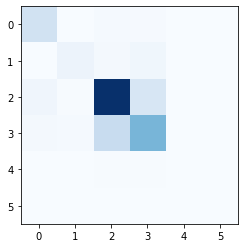

In [62]:
plt.figure()
plt.imshow(a, interpolation='nearest', cmap=plt.cm.Blues)

## b) Deep learning with Tensorflow


In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model

In [25]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

### 1. Feedforward neural network with dense layers

In [26]:
class SimpleModel:
  def __init__(self):
    self.model = keras.Sequential()
    self.model.add(layers.Dense(128, activation="relu"))
    # self.model.add(layers.Dropout(0.2))
    self.model.add(layers.Dense(64, activation="relu"))
    # self.model.add(layers.Dropout(0.2))
    self.model.add(layers.Dense(32, activation="relu"))
    self.model.add(layers.Dense(6, activation='softmax'))
    self.model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

  def fit(self, X, y, validation_split=0, batch_size=128, epochs=5):
    y = keras.utils.to_categorical(y, 6)
    history = self.model.fit(X, y, validation_split=validation_split, batch_size=batch_size, epochs=epochs)
    return history

  def predict(self, X):
    preds = self.model.predict(X)
    res = []
    n = len(preds)
    for i in range(n):
      res.append(np.argmax(preds[i]))
    return res

In [44]:
model = SimpleModel()
history = model.fit(X_train, y_train, 
                    validation_split=0.1, 
                    batch_size=128, 
                    epochs=100)

Epoch 1/100
1744/1744 [==============================] - 4s 2ms/step - loss: 1.1007 - accuracy: 0.5894 - val_loss: 0.9037 - val_accuracy: 0.6279
Epoch 2/100
1744/1744 [==============================] - 4s 3ms/step - loss: 0.8658 - accuracy: 0.6332 - val_loss: 0.8508 - val_accuracy: 0.6462
Epoch 3/100
1744/1744 [==============================] - 4s 2ms/step - loss: 0.8247 - accuracy: 0.6481 - val_loss: 0.8330 - val_accuracy: 0.6494
Epoch 4/100
1744/1744 [==============================] - 5s 3ms/step - loss: 0.7933 - accuracy: 0.6627 - val_loss: 0.8174 - val_accuracy: 0.6594
Epoch 5/100
1744/1744 [==============================] - 4s 2ms/step - loss: 0.7479 - accuracy: 0.6807 - val_loss: 0.7729 - val_accuracy: 0.6643
Epoch 6/100
1744/1744 [==============================] - 5s 3ms/step - loss: 0.7115 - accuracy: 0.6916 - val_loss: 0.7262 - val_accuracy: 0.6930
Epoch 7/100
1744/1744 [==============================] - 5s 3ms/step - loss: 0.7020 - accuracy: 0.6954 - val_loss: 0.7045 - val_ac

1744/1744 [==============================] - 4s 3ms/step - loss: 0.6030 - accuracy: 0.7452 - val_loss: 0.6264 - val_accuracy: 0.7376
Epoch 58/100
1744/1744 [==============================] - 5s 3ms/step - loss: 0.6041 - accuracy: 0.7429 - val_loss: 0.6178 - val_accuracy: 0.7420
Epoch 59/100
1744/1744 [==============================] - 5s 3ms/step - loss: 0.6062 - accuracy: 0.7447 - val_loss: 0.6248 - val_accuracy: 0.7393
Epoch 60/100
1744/1744 [==============================] - 5s 3ms/step - loss: 0.6059 - accuracy: 0.7436 - val_loss: 0.6290 - val_accuracy: 0.7381
Epoch 61/100
1744/1744 [==============================] - 4s 3ms/step - loss: 0.6045 - accuracy: 0.7443 - val_loss: 0.6276 - val_accuracy: 0.7383
Epoch 62/100
1744/1744 [==============================] - 5s 3ms/step - loss: 0.6013 - accuracy: 0.7452 - val_loss: 0.6353 - val_accuracy: 0.7293
Epoch 63/100
1744/1744 [==============================] - 4s 3ms/step - loss: 0.6011 - accuracy: 0.7456 - val_loss: 0.6269 - val_accuracy

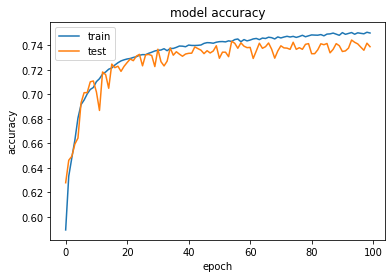

In [45]:
plot_accuracy(history)

In [46]:
preds = model.predict(X_test)
print(accuracy_score(preds, y_test))

0.7390084190832554


### 2. Bagging of neural networks

In [47]:
class Bagging:
  def __init__(self):
    self.list_models = []

  def most_frequent(self, List):
    return max(set(List), key = List.count)
  
  def fit(self, X, y, validation_split=0, batch_size=128, epochs=5):
    i = 1
    n = len(self.list_models)
    m = len(X)
    for i in range(n):
      print("Entrainement du numéro " + str(i+1) + "/" + str(n))
      step = m/n
      borne_inf = int(i*step)
      borne_sup = int((i+1)*step)
      self.list_models[i].fit(X[borne_inf:borne_sup], y[borne_inf:borne_sup], validation_split=validation_split, batch_size=batch_size, epochs=epochs)

  def predict(self, X):
    preds = np.array([model.predict(X) for model in self.list_models])
    n = len(preds)
    m = len(self.list_models)

    (nb_model, nb) = preds.shape
    res = []
    for i in range(nb):
      final_preds = self.most_frequent([preds[j][i] for j in range(nb_model)])
      res.append(final_preds)

    return res

  def add_model(self):
    model = SimpleModel()
    self.list_models.append(model)

In [48]:
global_model = Bagging()
for i in range(11):
  global_model.add_model()

In [49]:
global_model.fit(X_train, y_train, validation_split=0.1, batch_size=128, epochs=50)

Entrainement du numéro 1/11
Epoch 1/50
159/159 [==============================] - 1s 4ms/step - loss: 6.0032 - accuracy: 0.4906 - val_loss: 1.2103 - val_accuracy: 0.5353
Epoch 2/50
159/159 [==============================] - 0s 3ms/step - loss: 1.0896 - accuracy: 0.5761 - val_loss: 1.1003 - val_accuracy: 0.5534
Epoch 3/50
159/159 [==============================] - 0s 3ms/step - loss: 1.0272 - accuracy: 0.5884 - val_loss: 1.1048 - val_accuracy: 0.5357
Epoch 4/50
159/159 [==============================] - 0s 3ms/step - loss: 0.9857 - accuracy: 0.5902 - val_loss: 1.0058 - val_accuracy: 0.5827
Epoch 5/50
159/159 [==============================] - 0s 3ms/step - loss: 0.9913 - accuracy: 0.5933 - val_loss: 1.0896 - val_accuracy: 0.5605
Epoch 6/50
159/159 [==============================] - 0s 3ms/step - loss: 0.9489 - accuracy: 0.6104 - val_loss: 1.0050 - val_accuracy: 0.5747
Epoch 7/50
159/159 [==============================] - 0s 3ms/step - loss: 0.9710 - accuracy: 0.5968 - val_loss: 1.0010 -

159/159 [==============================] - 0s 3ms/step - loss: 0.9752 - accuracy: 0.6124 - val_loss: 0.9518 - val_accuracy: 0.6124
Epoch 9/50
159/159 [==============================] - 0s 3ms/step - loss: 0.9300 - accuracy: 0.6226 - val_loss: 0.9560 - val_accuracy: 0.6044
Epoch 10/50
159/159 [==============================] - 0s 3ms/step - loss: 0.9099 - accuracy: 0.6274 - val_loss: 0.9818 - val_accuracy: 0.6124
Epoch 11/50
159/159 [==============================] - 0s 3ms/step - loss: 0.9524 - accuracy: 0.6144 - val_loss: 0.8951 - val_accuracy: 0.6319
Epoch 12/50
159/159 [==============================] - 0s 3ms/step - loss: 0.9370 - accuracy: 0.6228 - val_loss: 0.9302 - val_accuracy: 0.6142
Epoch 13/50
159/159 [==============================] - 0s 3ms/step - loss: 0.8775 - accuracy: 0.6345 - val_loss: 0.9258 - val_accuracy: 0.6129
Epoch 14/50
159/159 [==============================] - 0s 3ms/step - loss: 0.8949 - accuracy: 0.6347 - val_loss: 0.8703 - val_accuracy: 0.6239
Epoch 15/50


159/159 [==============================] - 0s 3ms/step - loss: 0.8899 - accuracy: 0.6299 - val_loss: 1.2836 - val_accuracy: 0.6071
Epoch 16/50
159/159 [==============================] - 0s 3ms/step - loss: 0.9004 - accuracy: 0.6214 - val_loss: 1.0848 - val_accuracy: 0.5854
Epoch 17/50
159/159 [==============================] - 0s 3ms/step - loss: 0.8995 - accuracy: 0.6272 - val_loss: 0.9904 - val_accuracy: 0.6364
Epoch 18/50
159/159 [==============================] - 0s 3ms/step - loss: 0.8719 - accuracy: 0.6266 - val_loss: 1.0025 - val_accuracy: 0.5654
Epoch 19/50
159/159 [==============================] - 0s 3ms/step - loss: 0.8301 - accuracy: 0.6444 - val_loss: 0.9366 - val_accuracy: 0.6483
Epoch 20/50
159/159 [==============================] - 0s 3ms/step - loss: 0.8800 - accuracy: 0.6373 - val_loss: 0.8897 - val_accuracy: 0.6302
Epoch 21/50
159/159 [==============================] - 0s 3ms/step - loss: 0.8775 - accuracy: 0.6351 - val_loss: 0.9115 - val_accuracy: 0.6364
Epoch 22/50

159/159 [==============================] - 0s 3ms/step - loss: 0.8496 - accuracy: 0.6395 - val_loss: 0.8622 - val_accuracy: 0.6621
Epoch 23/50
159/159 [==============================] - 0s 2ms/step - loss: 0.8290 - accuracy: 0.6495 - val_loss: 0.9048 - val_accuracy: 0.6417
Epoch 24/50
159/159 [==============================] - 0s 3ms/step - loss: 0.8491 - accuracy: 0.6443 - val_loss: 1.0696 - val_accuracy: 0.5885
Epoch 25/50
159/159 [==============================] - 0s 3ms/step - loss: 0.8434 - accuracy: 0.6435 - val_loss: 0.8719 - val_accuracy: 0.6568
Epoch 26/50
159/159 [==============================] - 0s 3ms/step - loss: 0.8256 - accuracy: 0.6513 - val_loss: 0.8662 - val_accuracy: 0.6355
Epoch 27/50
159/159 [==============================] - 0s 3ms/step - loss: 0.8232 - accuracy: 0.6524 - val_loss: 0.8860 - val_accuracy: 0.6497
Epoch 28/50
159/159 [==============================] - 0s 3ms/step - loss: 0.8265 - accuracy: 0.6474 - val_loss: 0.8927 - val_accuracy: 0.6248
Epoch 29/50

159/159 [==============================] - 0s 3ms/step - loss: 0.8239 - accuracy: 0.6466 - val_loss: 0.8473 - val_accuracy: 0.6576
Epoch 30/50
159/159 [==============================] - 0s 3ms/step - loss: 0.8169 - accuracy: 0.6474 - val_loss: 0.8578 - val_accuracy: 0.6528
Epoch 31/50
159/159 [==============================] - 0s 3ms/step - loss: 0.8213 - accuracy: 0.6417 - val_loss: 0.8375 - val_accuracy: 0.6399
Epoch 32/50
159/159 [==============================] - 0s 3ms/step - loss: 0.8237 - accuracy: 0.6442 - val_loss: 1.0009 - val_accuracy: 0.5836
Epoch 33/50
159/159 [==============================] - 0s 3ms/step - loss: 0.8140 - accuracy: 0.6475 - val_loss: 0.8503 - val_accuracy: 0.6452
Epoch 34/50
159/159 [==============================] - 0s 3ms/step - loss: 0.8026 - accuracy: 0.6480 - val_loss: 0.8436 - val_accuracy: 0.6417
Epoch 35/50
159/159 [==============================] - 0s 3ms/step - loss: 0.7937 - accuracy: 0.6571 - val_loss: 0.8665 - val_accuracy: 0.6479
Epoch 36/50

159/159 [==============================] - 1s 4ms/step - loss: 0.7983 - accuracy: 0.6601 - val_loss: 0.8323 - val_accuracy: 0.6559
Epoch 37/50
159/159 [==============================] - 1s 4ms/step - loss: 0.7928 - accuracy: 0.6645 - val_loss: 0.8173 - val_accuracy: 0.6537
Epoch 38/50
159/159 [==============================] - 1s 4ms/step - loss: 0.7960 - accuracy: 0.6601 - val_loss: 0.8749 - val_accuracy: 0.6350
Epoch 39/50
159/159 [==============================] - 1s 4ms/step - loss: 0.7963 - accuracy: 0.6601 - val_loss: 0.8238 - val_accuracy: 0.6448
Epoch 40/50
159/159 [==============================] - 1s 4ms/step - loss: 0.7885 - accuracy: 0.6641 - val_loss: 0.7996 - val_accuracy: 0.6678
Epoch 41/50
159/159 [==============================] - 1s 4ms/step - loss: 0.8030 - accuracy: 0.6587 - val_loss: 0.7974 - val_accuracy: 0.6590
Epoch 42/50
159/159 [==============================] - 1s 4ms/step - loss: 0.7791 - accuracy: 0.6666 - val_loss: 0.8592 - val_accuracy: 0.6408
Epoch 43/50

159/159 [==============================] - 1s 4ms/step - loss: 0.7757 - accuracy: 0.6696 - val_loss: 0.8115 - val_accuracy: 0.6506
Epoch 44/50
159/159 [==============================] - 1s 4ms/step - loss: 0.7840 - accuracy: 0.6676 - val_loss: 0.7719 - val_accuracy: 0.6705
Epoch 45/50
159/159 [==============================] - 1s 4ms/step - loss: 0.7721 - accuracy: 0.6725 - val_loss: 0.7909 - val_accuracy: 0.6674
Epoch 46/50
159/159 [==============================] - 1s 4ms/step - loss: 0.7755 - accuracy: 0.6699 - val_loss: 0.7544 - val_accuracy: 0.6763
Epoch 47/50
159/159 [==============================] - 1s 4ms/step - loss: 0.7646 - accuracy: 0.6716 - val_loss: 0.7546 - val_accuracy: 0.6851
Epoch 48/50
159/159 [==============================] - 1s 4ms/step - loss: 0.7513 - accuracy: 0.6825 - val_loss: 0.7424 - val_accuracy: 0.6851
Epoch 49/50
159/159 [==============================] - 1s 4ms/step - loss: 0.7446 - accuracy: 0.6787 - val_loss: 0.7542 - val_accuracy: 0.6714
Epoch 50/50

159/159 [==============================] - 1s 4ms/step - loss: 0.7060 - accuracy: 0.6946 - val_loss: 0.7094 - val_accuracy: 0.6993
Entrainement du numéro 9/11
Epoch 1/50
159/159 [==============================] - 1s 3ms/step - loss: 3.4003 - accuracy: 0.4974 - val_loss: 1.3122 - val_accuracy: 0.5384
Epoch 2/50
159/159 [==============================] - 0s 3ms/step - loss: 1.1056 - accuracy: 0.5647 - val_loss: 1.0928 - val_accuracy: 0.5672
Epoch 3/50
159/159 [==============================] - 1s 4ms/step - loss: 1.0259 - accuracy: 0.5810 - val_loss: 0.9531 - val_accuracy: 0.5858
Epoch 4/50
159/159 [==============================] - 1s 4ms/step - loss: 1.0173 - accuracy: 0.5826 - val_loss: 0.9879 - val_accuracy: 0.5933
Epoch 5/50
159/159 [==============================] - 1s 4ms/step - loss: 0.9640 - accuracy: 0.5963 - val_loss: 0.9969 - val_accuracy: 0.5761
Epoch 6/50
159/159 [==============================] - 1s 4ms/step - loss: 0.9416 - accuracy: 0.6024 - val_loss: 0.9319 - val_accura

159/159 [==============================] - 0s 3ms/step - loss: 0.9270 - accuracy: 0.6068 - val_loss: 1.0018 - val_accuracy: 0.6053
Epoch 8/50
159/159 [==============================] - 0s 3ms/step - loss: 0.8913 - accuracy: 0.6232 - val_loss: 0.8859 - val_accuracy: 0.6124
Epoch 9/50
159/159 [==============================] - 1s 4ms/step - loss: 0.8704 - accuracy: 0.6270 - val_loss: 0.8843 - val_accuracy: 0.6217
Epoch 10/50
159/159 [==============================] - 1s 4ms/step - loss: 0.8720 - accuracy: 0.6289 - val_loss: 0.9096 - val_accuracy: 0.6160
Epoch 11/50
159/159 [==============================] - 1s 4ms/step - loss: 0.8813 - accuracy: 0.6245 - val_loss: 0.9069 - val_accuracy: 0.6151
Epoch 12/50
159/159 [==============================] - 1s 4ms/step - loss: 0.8703 - accuracy: 0.6306 - val_loss: 0.9046 - val_accuracy: 0.6102
Epoch 13/50
159/159 [==============================] - 1s 4ms/step - loss: 0.8734 - accuracy: 0.6199 - val_loss: 0.8921 - val_accuracy: 0.6195
Epoch 14/50
1

159/159 [==============================] - 1s 3ms/step - loss: 0.9026 - accuracy: 0.6225 - val_loss: 0.9068 - val_accuracy: 0.6275
Epoch 15/50
159/159 [==============================] - 1s 4ms/step - loss: 0.8805 - accuracy: 0.6314 - val_loss: 0.8676 - val_accuracy: 0.6350
Epoch 16/50
159/159 [==============================] - 1s 4ms/step - loss: 0.8821 - accuracy: 0.6221 - val_loss: 0.8440 - val_accuracy: 0.6497
Epoch 17/50
159/159 [==============================] - 1s 4ms/step - loss: 0.8538 - accuracy: 0.6361 - val_loss: 0.8386 - val_accuracy: 0.6608
Epoch 18/50
159/159 [==============================] - 1s 4ms/step - loss: 0.8387 - accuracy: 0.6443 - val_loss: 1.0186 - val_accuracy: 0.5894
Epoch 19/50
159/159 [==============================] - 1s 4ms/step - loss: 0.8530 - accuracy: 0.6364 - val_loss: 0.9059 - val_accuracy: 0.6239
Epoch 20/50
159/159 [==============================] - 1s 4ms/step - loss: 0.8505 - accuracy: 0.6380 - val_loss: 0.8785 - val_accuracy: 0.6466
Epoch 21/50

In [50]:
preds = global_model.predict(X_test)

In [51]:
print(accuracy_score(preds, y_test))

0.7028644237282669


### 3. LSTM model with data separation

In [52]:
class RecurrentNetwork:
  def __init__(self, X1, X2):
    input1 = keras.Input(shape=X1.shape[1], name="Input1")
    input2 = keras.Input(shape=X2.shape[1], name="Input2")

    output1 = keras.layers.Embedding(10, 10)(input1)
    output1 = keras.layers.LSTM(32, return_sequences=True)(output1)
    output1 = keras.layers.Flatten()(output1)

    input2 = keras.Input(shape=X2.shape[1], name="Input2")
    concat_layer= keras.layers.Concatenate(name="Concat")([output1, input2])

    output2 = keras.layers.Dense(64, activation='relu', name="Dense4")(concat_layer)
    output2 = keras.layers.Dense(32, activation='relu', name="Dense5")(concat_layer)
    output2 = keras.layers.Dense(6, activation='softmax', name="Dense6")(output2)

    self.model = Model([input1, input2], output2)
    self.model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

  def fit(self, X, y, validation_split=0, batch_size=128, epochs=5):
    y = keras.utils.to_categorical(y, 6)
    history = self.model.fit(X, y, validation_split=validation_split, batch_size=batch_size, epochs=epochs)
    return history

  def predict(self, X):
    preds = self.model.predict(X)
    res = []
    n = len(preds)
    for i in range(n):
      res.append(np.argmax(preds[i]))
    return res


In [39]:
# We separate the "change_status_date" columns
def separate_data(X):
  return X.iloc[:, :5], X.iloc[:, 5:]

X1, X2 = separate_data(X)
X1_train, X2_train = separate_data(X_train)
X1_test, X2_test = separate_data(X_test)

In [53]:
# Model training
model = RecurrentNetwork(X1, X2)
history = model.fit([X1_train, X2_train], y_train, 
                    validation_split=0.1, 
                    batch_size=256, 
                    epochs=50)

Epoch 1/50
1090/1090 [==============================] - 18s 15ms/step - loss: 3.3363 - accuracy: 0.5760 - val_loss: 0.9139 - val_accuracy: 0.6451
Epoch 2/50
1090/1090 [==============================] - 18s 17ms/step - loss: 0.8343 - accuracy: 0.6541 - val_loss: 0.8620 - val_accuracy: 0.6420
Epoch 3/50
1090/1090 [==============================] - 19s 17ms/step - loss: 0.7628 - accuracy: 0.6759 - val_loss: 0.7500 - val_accuracy: 0.6990
Epoch 4/50
1090/1090 [==============================] - 14s 13ms/step - loss: 0.7450 - accuracy: 0.6840 - val_loss: 0.7288 - val_accuracy: 0.7018
Epoch 5/50
1090/1090 [==============================] - 16s 15ms/step - loss: 0.7325 - accuracy: 0.6870 - val_loss: 0.7338 - val_accuracy: 0.6941
Epoch 6/50
1090/1090 [==============================] - 17s 15ms/step - loss: 0.7267 - accuracy: 0.6897 - val_loss: 0.7169 - val_accuracy: 0.7016
Epoch 7/50
1090/1090 [==============================] - 15s 14ms/step - loss: 0.7263 - accuracy: 0.6879 - val_loss: 0.7257 -

In [43]:
preds = model.predict([X1_test, X2_test])
print(accuracy_score(preds, y_test))

0.714493080868359


# **4) Submission**

### Final training of the chosen model

In [71]:
## Train a simple OnveVsRestClassifier using featurized data
# model = RandomForestClassifier(n_estimators=300, criterion='entropy', max_features='auto')
model = XGBClassifier(objective="multi:softprob")
model.fit(X,y)

[16:56:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

### Predictions

In [72]:
# Predictions with the chosen model
preds_submission = model.predict(df_submission)

## Save results to submission file
preds_submission_df = pd.DataFrame(preds_submission, columns=['change_type'])
preds_submission_df.to_csv("sample_submission.csv", index=True, index_label='Id')